##  Import Libraries

In [1]:
%matplotlib inline

import numpy as np
import nibabel as nib
from nilearn import datasets
import os
import zipfile
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_probability as tfp
from nilearn import plotting
import nibabel as nib
from scipy import ndimage
import matplotlib.pyplot as plt
from sklearn.utils import check_random_state
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model
import random
from scipy import ndimage
import cv2

tfd = tfp.distributions
print("TFP Version", tfp.__version__)
print("TF  Version",tf.__version__)

/usr/local/lib/python3.6/dist-packages/nilearn/__init__.py:69: FutureWarning: Python 3.6 support is deprecated and will be removed in release 0.10 of Nilearn. Consider switching to Python 3.8 or 3.9.
  _python_deprecation_warnings()


TFP Version 0.12.1
TF  Version 2.4.0


## Load Dataset

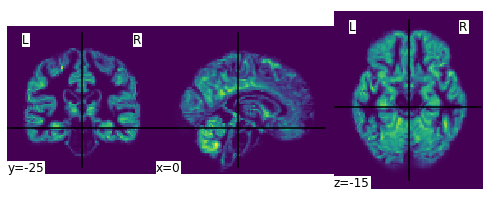

In [2]:
dataset_files = datasets.fetch_oasis_vbm(legacy_format=False)
age = dataset_files.ext_vars['age'].astype(float)
age = np.array(age)
gm_imgs = np.array(dataset_files.gray_matter_maps)
plotting.plot_img(gm_imgs[0])

## Preprocess Data

In [3]:
def read_nifti_file(filepath):
    """Read and load volume"""
    # Read file
    scan = nib.load(filepath)
    # Get raw data
    scan = scan.get_fdata()
    return scan

def normalize(volume):
    """Normalize the volume"""
    min = np.min(volume)
    max = np.max(volume) 
    volume = (volume - min) / (max - min)
    volume = volume.astype("float32")
    return volume

def resize_volume(img):
    """Resize across z-axis"""
    # Set the desired depth
    desired_height = 91
    desired_width = 109
    desired_depth = 91
    # Get current depth
    current_height = img.shape[0]
    current_width = img.shape[1]
    current_depth = img.shape[2]
    # Compute depth factor
    depth = current_depth / desired_depth
    width = current_width / desired_width
    height = current_height / desired_height
    depth_factor = 1 / depth
    width_factor = 1 / width
    height_factor = 1 / height
    # Rotate
    #img = ndimage.rotate(img, 90, reshape=False)
    img = np.rot90(img)
    # Resize across z-axis
    #img = ndimage.zoom(img, (width_factor, height_factor, depth_factor), order=1)
    return img

def process_scan(path):
    """Read and resize volume"""
    # Read scan
    volume = read_nifti_file(path)
    # Normalize
    volume = normalize(volume)
    # Resize width, height and depth
    volume = resize_volume(volume)
    return volume

In [4]:
df = np.array([process_scan(path) for path in gm_imgs])
print(df.shape)

(403, 109, 91, 91)


In [5]:
only_old = False
if only_old:
    old_idx = [age>25]
    df = df[old_idx]
    age = age[old_idx]

In [6]:
log_age = np.log(age)
mu,sd = np.mean(log_age), np.std(log_age)
print(mu,sd)
z_age = (log_age -mu) /sd

3.814354769973912 0.5644529842116628


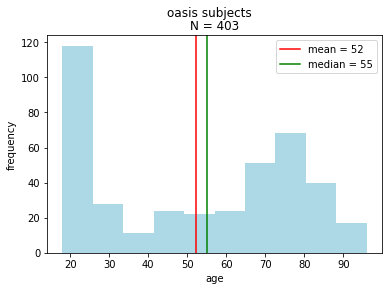

In [7]:
import matplotlib.pyplot as plt
plt.hist(age, color = "lightblue")
plt.xlabel('age')
plt.ylabel('frequency')
plt.title(str('N = ' + str(len(age))))
plt.suptitle('oasis subjects')
plt.axvline(np.mean(age), color = 'r', label = str("mean = "+ str(int(np.mean(age)))))
plt.axvline(np.median(age), color = 'g', label =  str("median = "+ str(int(np.median(age)))))
plt.legend(loc='best')
plt.show()

In [8]:
# Split data into training set and test set
rng = check_random_state(42)

X_train, X_test, y_train, y_test = train_test_split(df, z_age, train_size=0.8, random_state=rng)
X_test, X_valid, y_test, y_valid = train_test_split(X_test, y_test, train_size=0.5, random_state=rng)


## Build Model

In [9]:
#def NLL(y, distr):
#    return -distr.log_prob(y) 
#
#def my_dist(params): 
#    return tfd.Normal(loc=params[:,0:1],scale=1e-3 + tf.math.softplus(0.05 * params[:,1:2]))# both parameters are learnable
#
# model
initializer = keras.initializers.he_normal(seed = 2202)

inputs = keras.Input((109, 91, 91,1))
x = layers.BatchNormalization()(inputs)

# conv block 0
x = layers.Convolution3D(16, kernel_size=(3, 3, 3), padding = 'same', activation = 'relu', kernel_initializer = initializer)(x)
x = layers.BatchNormalization(center=True, scale=True)(x)
x = layers.Convolution3D(16, kernel_size=(3, 3, 3), padding = 'same', activation = 'relu', kernel_initializer = initializer)(x)
x = layers.BatchNormalization(center=True, scale=True)(x)
x = layers.MaxPooling3D(pool_size=(2, 2, 2))(x)
x = layers.Dropout(0.3)(x)

# conv block 1
x = layers.Convolution3D(32, kernel_size=(3, 3, 3), padding = 'same', activation = 'relu', kernel_initializer = initializer)(x)
x = layers.BatchNormalization(center=True, scale=True)(x)
x = layers.Convolution3D(32, kernel_size=(3, 3, 3), padding = 'same', activation = 'relu', kernel_initializer = initializer)(x)
x = layers.BatchNormalization(center=True, scale=True)(x)
x = layers.MaxPooling3D(pool_size=(2, 2, 2))(x)
x = layers.Dropout(0.3)(x)

# conv block 2
x = layers.Convolution3D(64, kernel_size=(3, 3, 3), padding = 'same', activation = 'relu', kernel_initializer = initializer)(x)
x = layers.BatchNormalization(center=True, scale=True)(x)
x = layers.Convolution3D(64, kernel_size=(3, 3, 3), padding = 'same', activation = 'relu', kernel_initializer = initializer)(x)
x = layers.BatchNormalization(center=True, scale=True)(x)
x = layers.MaxPooling3D(pool_size=(2, 2, 2))(x)
x = layers.Dropout(0.3)(x)

# conv block 3
x = layers.Convolution3D(128, kernel_size=(3, 3, 3), padding = 'same',activation = 'relu', kernel_initializer = initializer)(x)
x = layers.BatchNormalization(center=True, scale=True)(x)
x = layers.Convolution3D(128, kernel_size=(3, 3, 3), padding = 'same',activation = 'relu', kernel_initializer = initializer)(x)
x = layers.BatchNormalization(center=True, scale=True)(x)
x = layers.MaxPooling3D(pool_size=(2, 2, 2))(x)
x = layers.Dropout(0.3)(x)

# flat block
x = layers.GlobalAveragePooling3D()(x) 
x = layers.BatchNormalization(center=True, scale=True)(x)

x = layers.Dense(128, activation = 'relu')(x)
x = layers.BatchNormalization(center=True, scale=True)(x)
x = layers.Dropout(0.3)(x)

out = layers.Dense(units=1)(x)
#dist = tfp.layers.DistributionLambda(my_dist)(x) 

# Define the model.
model_3d = Model(inputs=inputs, outputs=out, name = "cnn_3d_")
model_3d.summary()

Model: "cnn_3d_"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 109, 91, 91, 1)]  0         
_________________________________________________________________
batch_normalization (BatchNo (None, 109, 91, 91, 1)    4         
_________________________________________________________________
conv3d (Conv3D)              (None, 109, 91, 91, 16)   448       
_________________________________________________________________
batch_normalization_1 (Batch (None, 109, 91, 91, 16)   64        
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 109, 91, 91, 16)   6928      
_________________________________________________________________
batch_normalization_2 (Batch (None, 109, 91, 91, 16)   64        
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 54, 45, 45, 16)    0   

## Augment 3D Data

In [10]:
import random
from scipy import ndimage

@tf.function
def rotate(volume):
    """Rotate the volume by a few degrees"""

    def scipy_rotate(volume):
        # define some rotation angles
        angles = [-20, -10, -5, 5, 10, 20]
        # pick angles at random
        angle = random.choice(angles)
        # rotate volume
        volume = ndimage.rotate(volume, angle, reshape=False)
        volume[volume < 0] = 0
        volume[volume > 1] = 1
        return volume

    augmented_volume = tf.numpy_function(scipy_rotate, [volume], tf.float32)
    return augmented_volume


@tf.function
def zoom(volume):
    """Rotate the volume by a few degrees"""

    def random_zoom3d(X_im, min_zoom = 0.7 , max_zoom = 1.4):
        z = np.random.sample() *(max_zoom-min_zoom) + min_zoom
        zoom_matrix = np.array([[z, 0, 0, 0],
                            [0, z, 0, 0],
                            [0, 0, z, 0],
                            [0, 0, 0, 1]])
        volume = ndimage.affine_transform(X_im, zoom_matrix, mode = "nearest", order = 1)
        return volume

    augmented_volume = tf.numpy_function(random_zoom3d, [volume], tf.float32)
    return augmented_volume


@tf.function
def gauss(volume):
    """Rotate the volume by a few degrees"""

    def random_gaussianfilter3d(X_im, sigma_max=0.2):
        sigma = np.random.uniform(0, sigma_max)
        volume = ndimage.gaussian_filter(X_im, sigma, mode = "nearest")
        return volume

    augmented_volume = tf.numpy_function(random_gaussianfilter3d, [volume], tf.float32)
    return augmented_volume


def train_preprocessing(volume, label):
    """Process training data by rotating and adding a channel."""
    # Rotate volume
    volume = rotate(volume)
    volume = zoom(volume)
    volume = gauss(volume)
    volume = tf.expand_dims(volume, axis=3)
    return volume, label


def validation_preprocessing(volume, label):
    """Process validation data by only adding a channel."""
    volume = tf.expand_dims(volume, axis=3)
    return volume, label



In [11]:
# Define data loaders.
train_loader = tf.data.Dataset.from_tensor_slices((X_train, y_train))
validation_loader = tf.data.Dataset.from_tensor_slices((X_valid, y_valid))

batch_size = 16

# Augment the on the fly during training.
train_dataset = (
    train_loader.shuffle(len(X_train))
    .map(train_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)
# Only rescale.
validation_dataset = (
    validation_loader.shuffle(len(X_valid))
    .map(validation_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)


## Run Model

In [12]:
model_3d.compile(
    loss="mse",
    optimizer=keras.optimizers.Adam(),
    metrics=[tf.keras.metrics.MeanAbsoluteError()]
)

train = False
if train:
    
    # Define callbacks.
    checkpoint_cb = keras.callbacks.ModelCheckpoint(
        "3d_image_reg.h5", save_best_only=True
    )
    early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_loss", patience=100)
    
    # Train the model, doing validation at the end of each epoch
    epochs = 1
    hist = model_3d.fit(
        train_dataset,
        validation_data=validation_dataset,
        epochs=epochs,
        shuffle=True,
        verbose=1,
        callbacks=[checkpoint_cb, early_stopping_cb],
    )
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.xlabel('epochs')
    plt.ylabel('mse')
    plt.show()

## Model Evaluation

In [13]:
model_3d.load_weights('3d_image_reg.h5')
loss, log_mae = model_3d.evaluate(x=X_test, y=y_test)

2/2 [==============================] - 23s 10s/step - loss: 0.1932 - mean_absolute_error: 0.3115


In [14]:
#predict
y = np.exp(y_test  *sd + mu)
preds_log = model_3d.predict(X_test)
y_pred = np.exp(preds_log*sd + mu)
mae = np.median(abs(np.squeeze(y_pred) - y))
print("Model MAE: ", mae, "\nUnconditional MAE: ",np.mean(abs(np.mean(age) - y)) )

Model MAE:  5.315289497375483 
Unconditional MAE:  21.400000000000002


# Grad Cam

In [15]:
from skimage.transform import resize
from matplotlib import pyplot as plt

def grad_cam_3d(img, model_3d, layer):
    
    # Create a graph that outputs target convolution and output
    grad_model = tf.keras.models.Model([model_3d.inputs], [model_3d.get_layer(layer).output, model_3d.output])
    
    ###--Compute GRADIENT
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img)    
        loss = predictions[0][0]

    # Extract filters and gradients
    output = conv_outputs[0]
    grads = tape.gradient(loss, conv_outputs)[0]
    # Average gradients spatially
    weights = tf.reduce_mean(grads, axis=(0, 1, 2))
    # Build a ponderated map of filters according to gradients importance
    cam = np.zeros(output.shape[0:3], dtype=np.float32)
    for index, w in enumerate(weights):
        cam += w * output[:, :, :, index]

    capi=resize(cam,(img.shape[1:]))
    capi = np.maximum(capi,0)
    heatmap = (capi - capi.min()) / (capi.max() - capi.min())
    resized_img = img.reshape(img.shape[1:])
    
    return heatmap, resized_img



# Avg. Grad-CAM

In [16]:
h_l = []
i_l = []
for j in range(len(y_test)):
    
    heatmap, resized_img = grad_cam_3d(img = X_test[j:j+1], model_3d = model_3d , layer = model_3d.layers[-9].name)
    h_l.append(heatmap)
    i_l.append(resized_img)


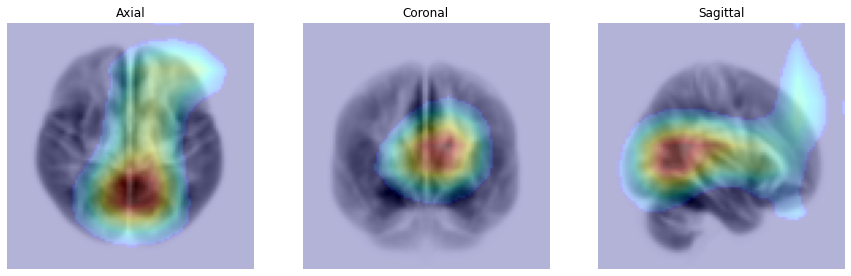

In [17]:
plt.figure(figsize = (15,45))
dsize = (91,91)
# axial average
plt.subplot(1,3,1)
plt.title('Axial')
axial = np.mean(np.array(h_l), (0,3))
th = np.max((np.mean(np.array(h_l), (0,3))))*0.2
axial[axial < th ] = 0
plt.imshow(cv2.resize(np.negative(np.mean(np.array(i_l), (0,3))),dsize=dsize), cmap='gray')
plt.imshow(cv2.resize(axial,dsize=dsize), alpha=0.3,cmap="jet")
plt.axis('off')
# coronal average
plt.subplot(1,3,2)
plt.title('Coronal')
coronal = np.mean(np.array(h_l), (0,1))
th = np.max((np.mean(np.array(h_l), (0,1))))*0.2
coronal[coronal < th ] = 0
plt.imshow(np.negative(np.rot90(np.mean(np.array(i_l), (0,1)))), cmap='gray')
plt.imshow(np.rot90(coronal), alpha=0.3,cmap="jet")
plt.axis('off')
# sagital average
plt.subplot(1,3,3)
plt.title('Sagittal')
sagital = np.mean(np.array(h_l), (0,2))
th = np.max((np.mean(np.array(h_l), (0,2))))*0.2
sagital[sagital < th ] = 0
plt.imshow(cv2.resize(np.negative(np.fliplr(np.rot90(np.mean(np.array(i_l), (0,2))))),dsize=dsize), cmap='gray')
plt.imshow(cv2.resize(np.fliplr(np.rot90(sagital)),dsize=dsize), alpha=0.3,cmap="jet")
plt.axis('off')

plt.show()

# layer Iteration

conv3d


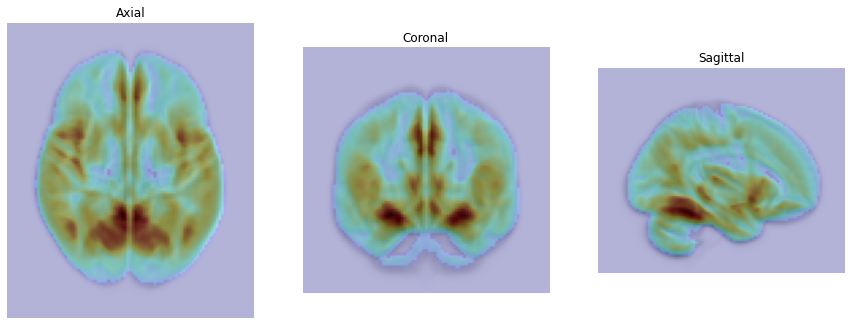

batch_normalization_1


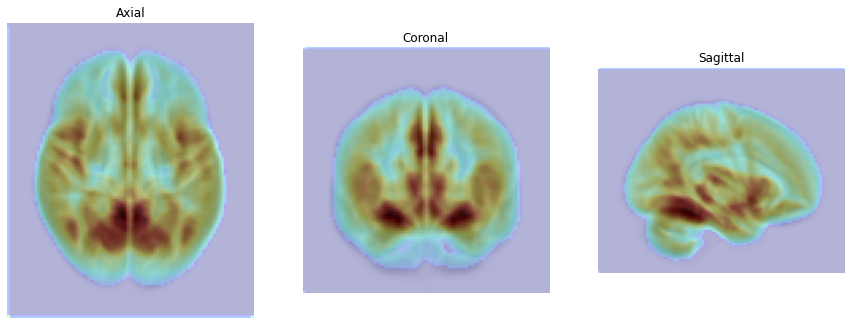

conv3d_1


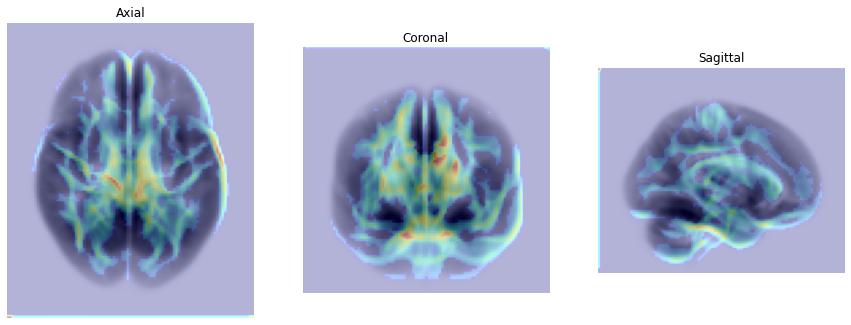

batch_normalization_2


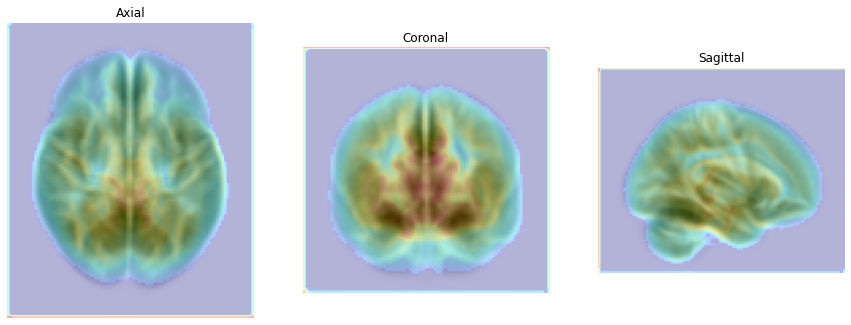

max_pooling3d


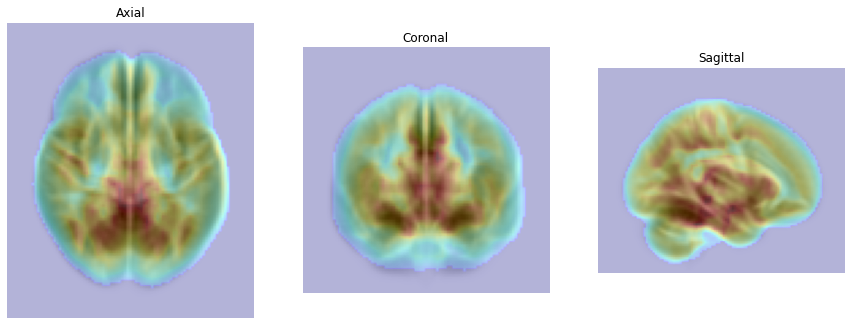

dropout


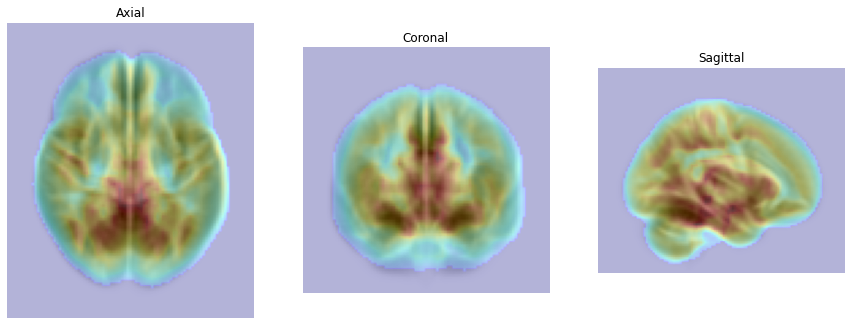

conv3d_2


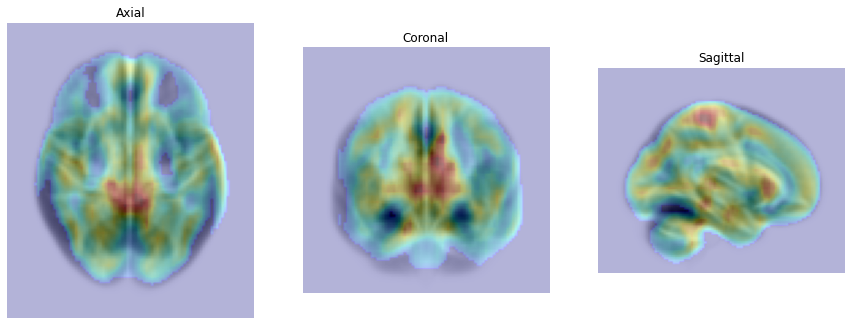

batch_normalization_3


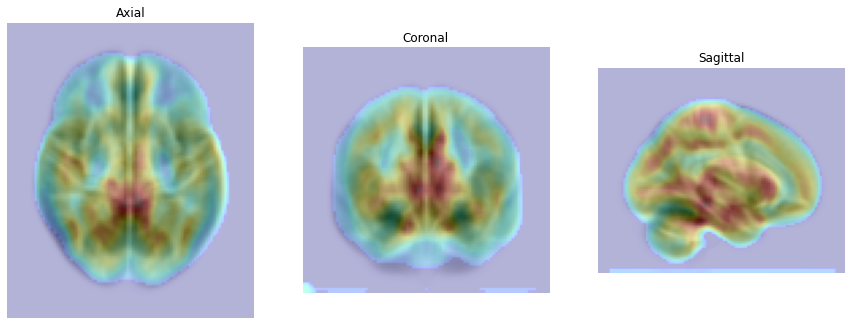

conv3d_3


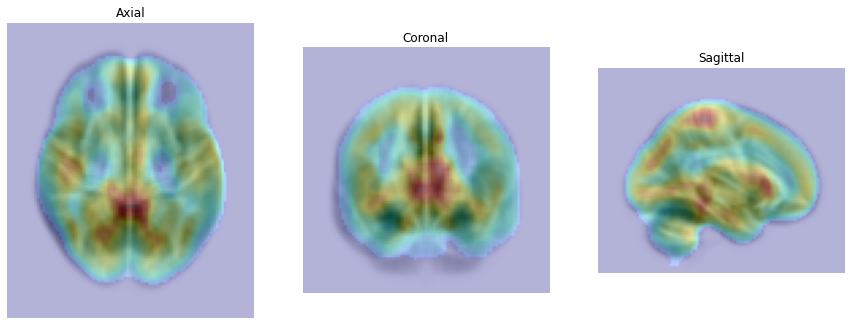

batch_normalization_4


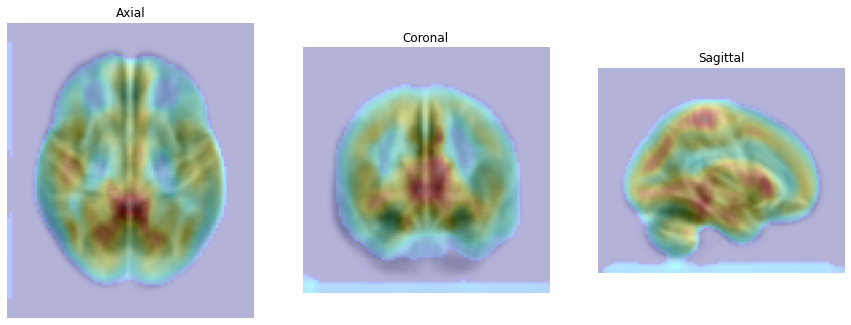

max_pooling3d_1


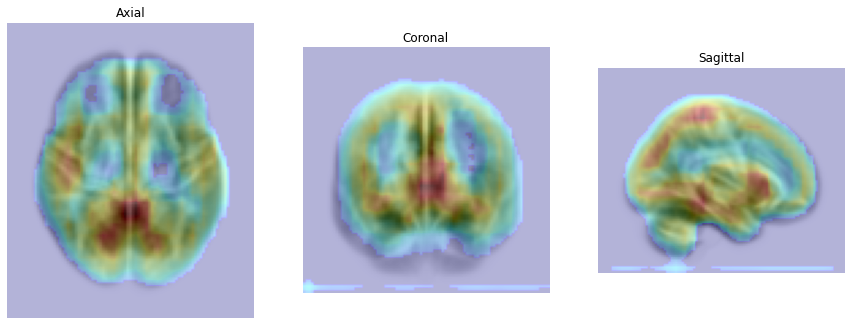

dropout_1


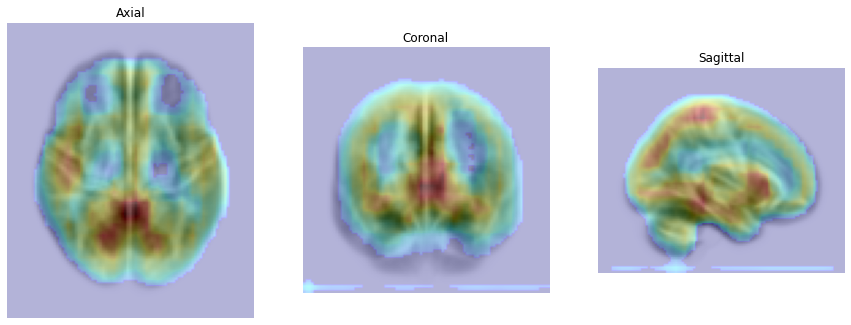

conv3d_4


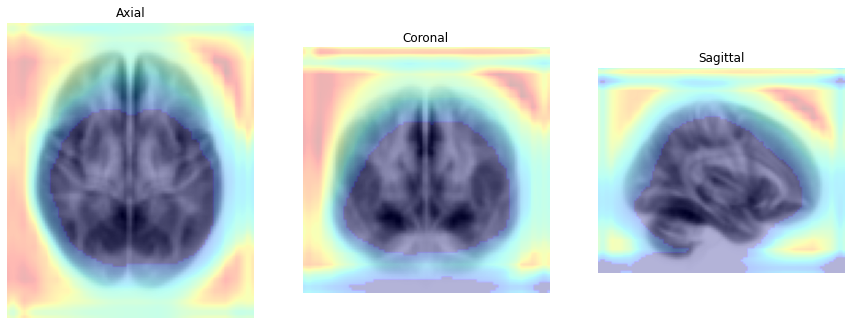

batch_normalization_5


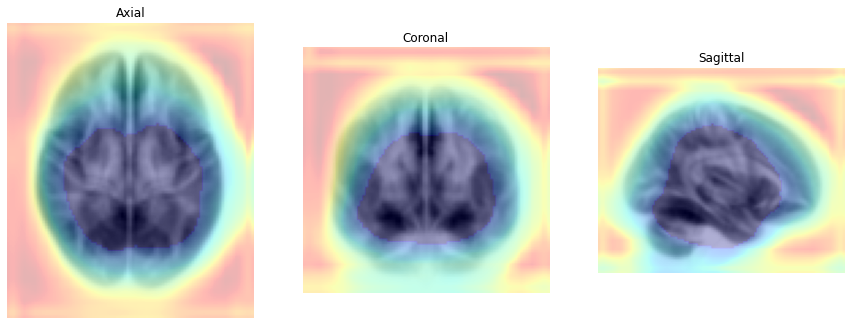

conv3d_5


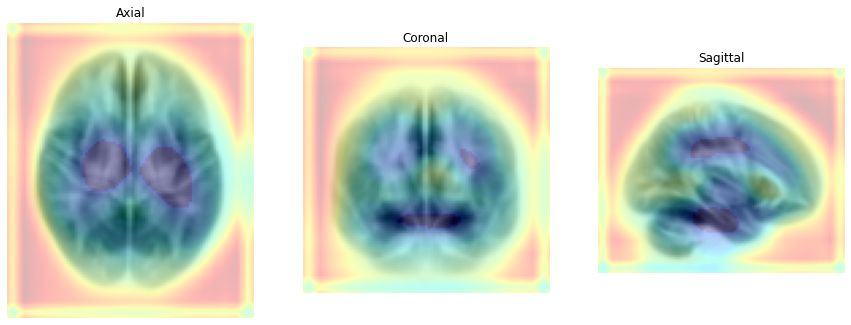

batch_normalization_6


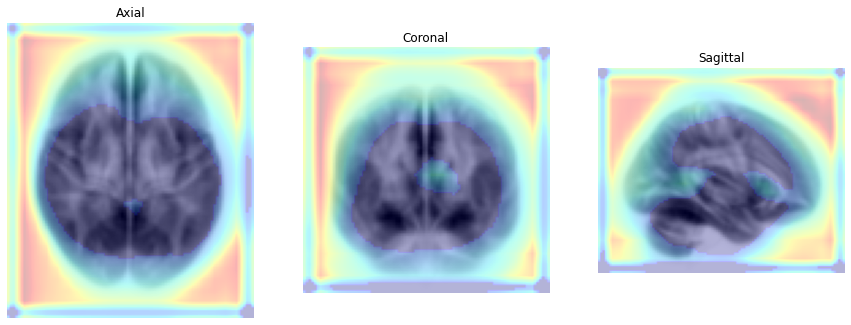

max_pooling3d_2


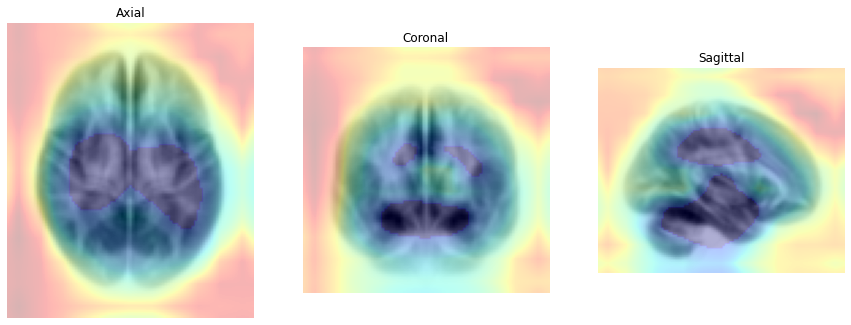

dropout_2


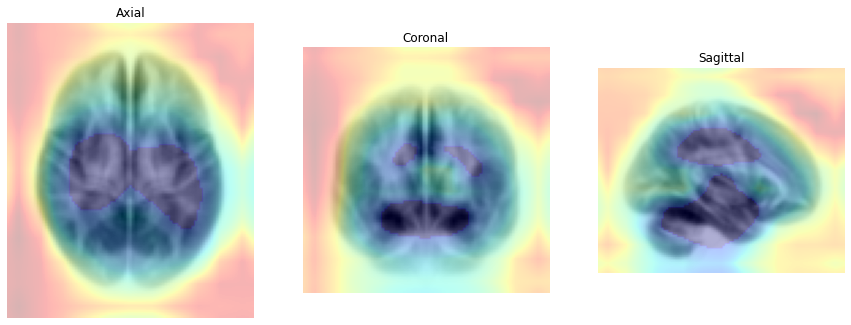

conv3d_6


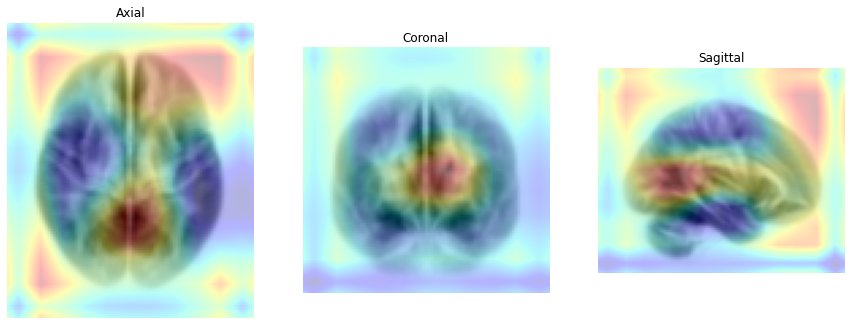

batch_normalization_7


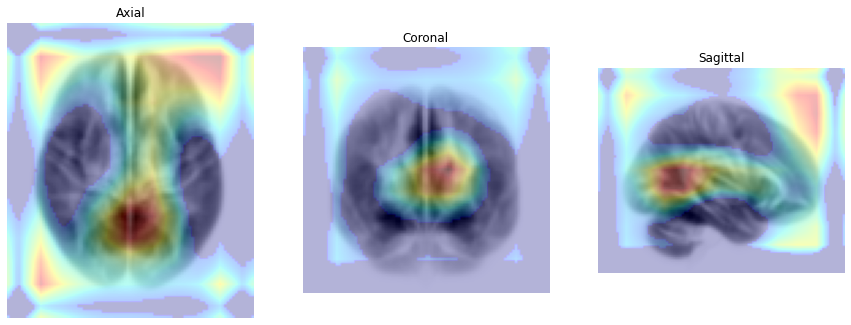

conv3d_7


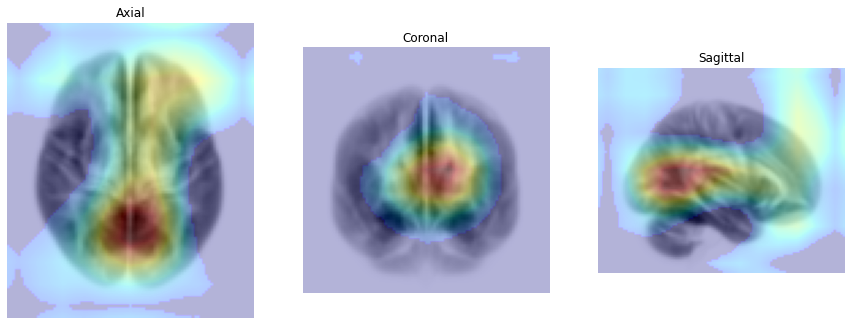

batch_normalization_8


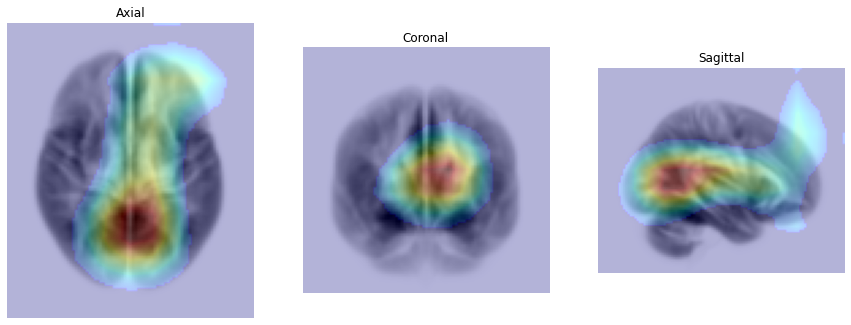

max_pooling3d_3


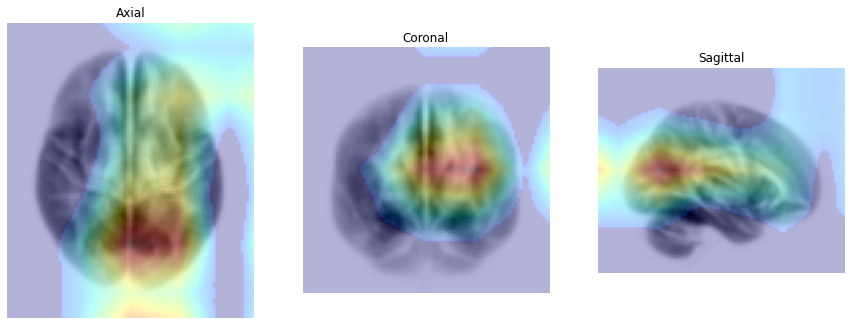

dropout_3


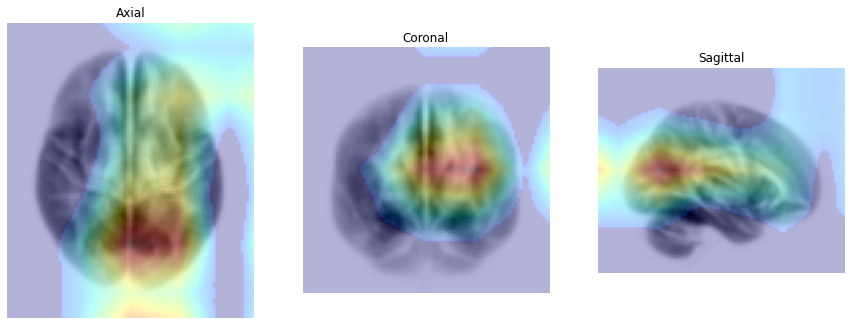

In [18]:
for i in model_3d.layers[2:-6]:
    layer = i.name
    
    
    h_l = []
    i_l = []
    for j in range(len(y_test)):
        
        heatmap, resized_img = grad_cam_3d(img = X_test[j:j+1], model_3d = model_3d , layer = layer)
        h_l.append(heatmap)
        i_l.append(resized_img)
    print(layer)
    plt.figure(figsize = (15,45))
    # axial average
    plt.subplot(1,3,1)
    plt.title('Axial')
    axial = np.mean(np.array(h_l), (0,3))
    th = np.max((np.mean(np.array(h_l), (0,3))))*0.2
    axial[axial < th ] = 0
    plt.imshow(np.negative(np.mean(np.array(i_l), (0,3))), cmap='gray')
    plt.imshow(axial, alpha=0.3,cmap="jet")
    plt.axis('off')
    # coronal average
    plt.subplot(1,3,2)
    plt.title('Coronal')
    coronal = np.mean(np.array(h_l), (0,1))
    th = np.max((np.mean(np.array(h_l), (0,1))))*0.2
    coronal[coronal < th ] = 0
    plt.imshow(np.negative(np.rot90(np.mean(np.array(i_l), (0,1)))), cmap='gray')
    plt.imshow(np.rot90(coronal), alpha=0.3,cmap="jet")
    plt.axis('off')
    # sagital average
    plt.subplot(1,3,3)
    plt.title('Sagittal')
    sagital = np.mean(np.array(h_l), (0,2))
    th = np.max((np.mean(np.array(h_l), (0,2))))*0.2
    sagital[sagital < th ] = 0
    plt.imshow(np.negative(np.fliplr(np.rot90(np.mean(np.array(i_l), (0,2))))), cmap='gray')
    plt.imshow(np.fliplr(np.rot90(sagital)), alpha=0.3,cmap="jet")
    plt.axis('off')
    
    plt.show()


# slice iteration

48.0


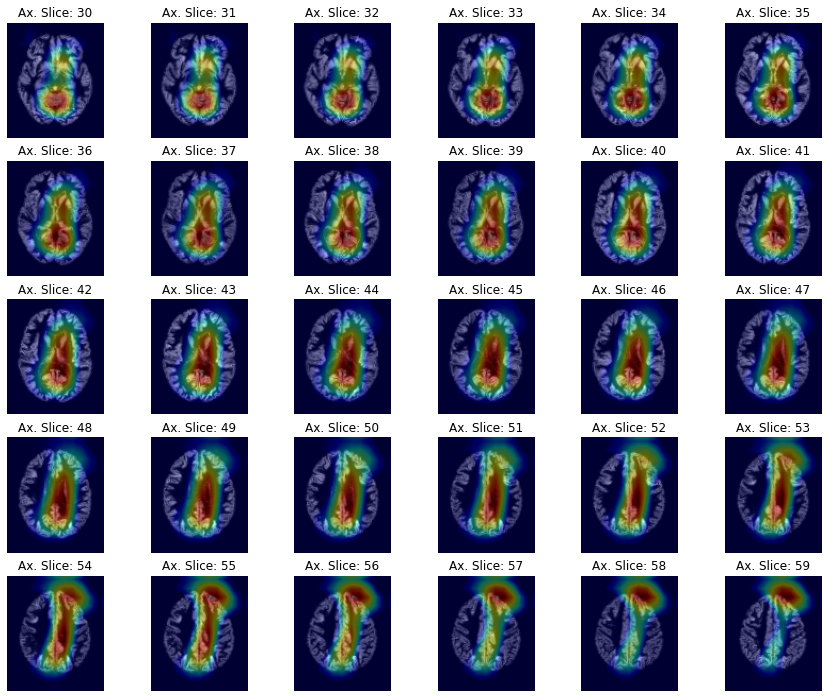

[48.]
[[50.]]


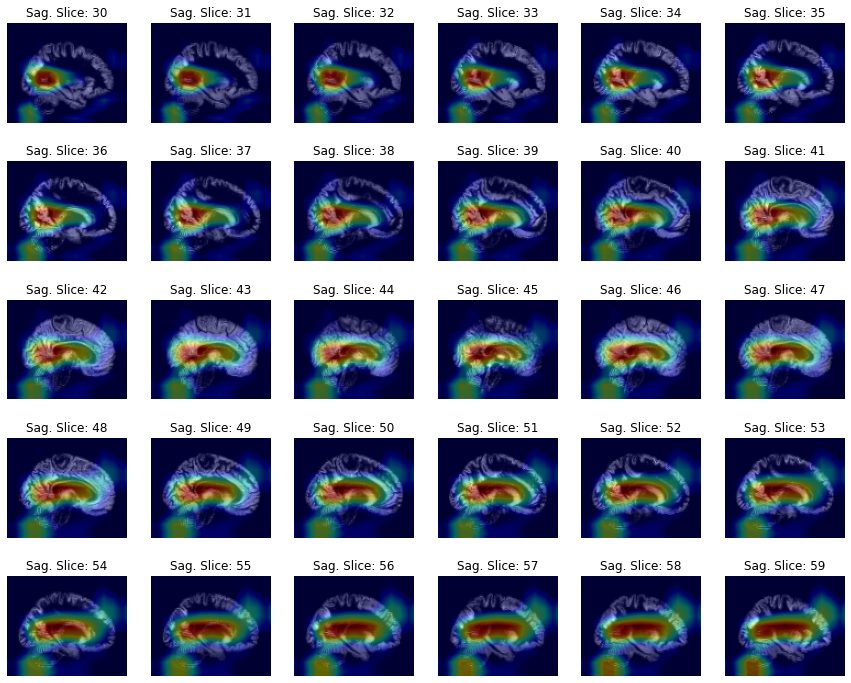

48.0


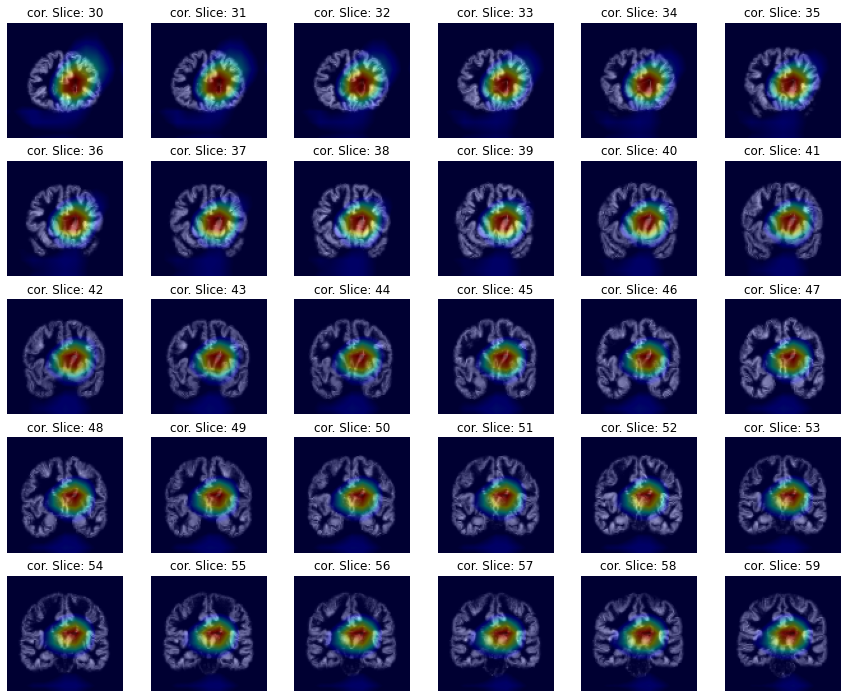

In [19]:
# axial

for j in range(1):
    heatmap, resized_img = grad_cam_3d(img = X_test[j:j+1], model_3d = model_3d , layer = model_3d.layers[-9].name)
    plt.figure(figsize=(15,25))
    print(np.round(np.exp(y_test[j]*sd+mu)))
    
    for ax_slice in range(30,60):
        fig = plt.subplot(10,6, ax_slice+1)
        fig.imshow(resized_img[:,:,ax_slice ], cmap='gray')
        fig.imshow(heatmap[:,:,ax_slice], alpha=0.4,cmap="jet")
        fig.set_title("Ax. Slice: " + str(ax_slice))
        fig.axis('off')
        
    plt.show()
    
# sagital

for j in range(1):
    heatmap, resized_img = grad_cam_3d(img = X_test[j:j+1], model_3d = model_3d , layer = model_3d.layers[-9].name)
    plt.figure(figsize=(15,25))
    print(np.round(np.exp(y_test[j:j+1]*sd+mu)))
    print(np.round(np.exp(model_3d.predict(X_test[j:j+1])*sd+mu)))
    
    for ax_slice in range(30,60):
        fig = plt.subplot(10,6, ax_slice+1)
        
        fig.imshow(np.fliplr(np.rot90(resized_img[:,ax_slice,: ])), cmap='gray')
        fig.imshow(np.fliplr(np.rot90(heatmap[:,ax_slice,:])), alpha=0.4,cmap="jet")
        
        fig.set_title("Sag. Slice: " + str(ax_slice))
        fig.axis('off')
        
    plt.show()
    
# coronal

for j in range(1):
    heatmap, resized_img = grad_cam_3d(img = X_test[j:j+1], model_3d = model_3d , layer = model_3d.layers[-9].name)
    plt.figure(figsize=(15,25))
    print(np.round(np.exp(y_test[j]*sd+mu)))
    
    for ax_slice in range(30,60):
        fig = plt.subplot(10,6, ax_slice+1)
        
        fig.imshow(np.rot90(resized_img[ax_slice,:,: ]), cmap='gray')
        fig.imshow(np.rot90(heatmap[ax_slice,:,:]), alpha=0.4,cmap="jet")
        
        fig.set_title("cor. Slice: " + str(ax_slice))
        fig.axis('off')
        
    plt.show()